[5.23341102e-08 1.60337148e-11 1.15867969e-13 7.09728286e-14
 2.33327977e-08 2.22667295e+05 2.63650379e-04 4.26301850e-02]


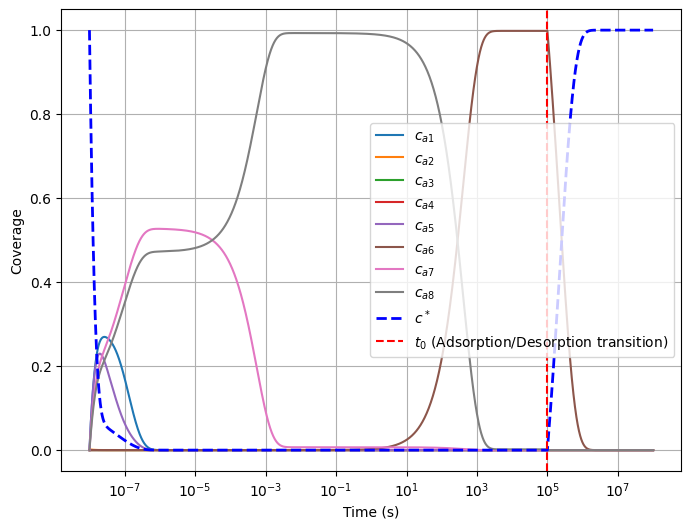

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib inline

# Physical constants
kB = 1.380649e-23   # Boltzmann constant (J/K)
h = 6.62607015e-34  # Planck constant (J·s)

def read_parameters(file_path):
    """
    Reads key=value pairs from a file and returns them as a dictionary.
    """
    parameters = {}
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            key, value = map(str.strip, line.split("=", 1))
            try:
                parameters[key] = float(value)
            except ValueError:
                if "," in value:
                    parameters[key] = tuple(map(float, value.split(",")))
                else:
                    parameters[key] = value
    return parameters

def ode_adsorption(t, y, k_ads_arr, k_des_arr):
    """ODE system for adsorption phase."""
    N = 8
    c_a = y[:N]       # c_a1..c_a8
    c_star = y[N]     # c^*

    dydt = np.zeros(N + 1)

    for i in range(N):
        dydt[i] = k_ads_arr[i] * c_star - k_des_arr[i] * c_a[i]

    sum_des = np.sum(k_des_arr * c_a)
    sum_ads = np.sum(k_ads_arr)
    dydt[N] = sum_des - sum_ads * c_star

    return dydt

def calculate_desorption(t, c_a_t0, k_des_arr, t0):
    """Calculate desorption coverage at time t."""
    t_diff = t - t0
    return c_a_t0 * np.exp(-k_des_arr * t_diff[:, None])

def main():
    # Read parameters from file "PARAMETER"
    param_file = "PARAMETER"
    params = read_parameters(param_file)

    # 解析 MobileTS 參數 (可為 True 或 False)
    mobile_ts = params.get("MobileTS", False)
    if isinstance(mobile_ts, str):
        mobile_ts = mobile_ts.strip().lower() == "true"

    T_target = params["T_target"]
    t_span = params["t_span"]
    t0 = params["t0"]
    A_in = params["A_in"]

    N = 8
    k_ads_array = np.zeros(N)
    k_des_array = np.zeros(N)
    tau_array = np.zeros(N)
    K_eq = np.zeros(N)


    # 計算每個分子的吸附/脫附速率常數
    for i in range(1, N + 1):
        prefix = f"molecule{i}_"

        p_bar = params[prefix + "p"]
        m_amu = params[prefix + "m"]
        Edes_eV = params[prefix + "Edes"]
        sigma = params[prefix + "sigma"]
        molecule_type = params[prefix + "molecule_type"]

        p = p_bar * 1e5
        A = A_in * 1e-20
        m_kg = m_amu * 1.660539e-27
        Edes_J = Edes_eV * 1.602176565e-19

        if mobile_ts:
            # 使用 MobileTS 模型公式（忽略分子型態與旋轉常數）
            k_ads_val = p * A / np.sqrt(2.0 * np.pi * m_kg * kB * T_target)
            k_des_val = (kB * T_target**2) / h**3 * (2.0 * A * np.pi * m_kg * kB) * np.exp(-Edes_J / (kB * T_target))
        else:
            # 原始公式依據分子型態區分
            if molecule_type == "linear":
                theta_rot = params[prefix + "theta_rot_linear"]
                k_ads_val = p * A / np.sqrt(2.0 * np.pi * m_kg * kB * T_target) * (sigma * theta_rot / T_target)
                k_des_val = (kB * T_target**3) / h**3 * (2.0 * A * np.pi * m_kg * kB / (sigma * theta_rot)) * np.exp(-Edes_J / (kB * T_target))
            elif molecule_type == "nonlinear":
                theta_rot_A = params[prefix + "theta_rot_A"]
                theta_rot_B = params[prefix + "theta_rot_B"]
                theta_rot_C = params[prefix + "theta_rot_C"]
                theta_rot_product = theta_rot_A * theta_rot_B * theta_rot_C
                k_ads_val = p * A / np.sqrt(2.0 * np.pi * m_kg * kB * T_target) * (sigma / np.sqrt(np.pi)) * np.sqrt(theta_rot_product / T_target**3)
                k_des_val = (kB * T_target**3.5) / h**3 * (2.0 * A * np.pi**1.5 * m_kg * kB / (sigma * np.sqrt(theta_rot_product))) * np.exp(-Edes_J / (kB * T_target))
            else:
                raise ValueError(f"Unknown molecule type: {molecule_type}")

        k_ads_array[i - 1] = k_ads_val
        k_des_array[i - 1] = k_des_val
        tau_array[i - 1] = 1.0 / k_des_val
        K_eq[i - 1] = k_ads_val / k_des_val

    # 初始條件設定
    print(tau_array)
    c0 = 1.0
    y0 = np.zeros(N + 1)
    y0[-1] = c0
    log_start = np.log10(t_span[0])
    log_end = np.log10(t0)

    # Adsorption phase
    t_eval = np.logspace(log_start, log_end, 2000)
    sol_ads = solve_ivp(ode_adsorption, (t_span[0], t0), y0, t_eval=t_eval, args=(k_ads_array, k_des_array), method="BDF")
    if not sol_ads.success:
        print("ODE solver failed:", sol_ads.message)
        return

    c_a_t0 = sol_ads.y[:N, -1]

    # Desorption phase
    t_eval_des = np.logspace(np.log10(t0), np.log10(t_span[1]), 500)
    c_a_des = calculate_desorption(t_eval_des, c_a_t0, k_des_array, t0)

    # Combine results
    t_combined = np.concatenate([sol_ads.t, t_eval_des])
    c_a_combined = np.hstack([sol_ads.y[:N, :], c_a_des.T])

    # Plot results
    plt.figure(figsize=(8, 6))
    for i in range(N):
        plt.plot(t_combined, c_a_combined[i, :], label=f'$c_{{a{i + 1}}}$')

    c_star_combined = c0 - np.sum(c_a_combined, axis=0)
    plt.plot(t_combined, c_star_combined, label='$c^*$', linestyle='--', linewidth=2, color='blue')
    plt.axvline(x=t0, color='red', linestyle='--', label='$t_0$ (Adsorption/Desorption transition)')

    plt.xscale("log")
    plt.xlabel("Time (s)")
    plt.ylabel("Coverage")
    plt.grid()
    plt.legend()
    plt.savefig("coverage_combined.png", dpi=600)
    plt.show()

    # Save results to .dat files
    data_out = np.column_stack([t_combined, *c_a_combined, c_star_combined])
    header_line = "Time c_a1 c_a2 c_a3 c_a4 c_a5 c_a6 c_a7 c_a8 c_star"
    np.savetxt("coverage_results.dat", data_out, header=header_line, comments='', fmt='%.12e')
    np.savetxt("K_tau_results.dat", np.column_stack([K_eq, tau_array, k_ads_array, k_des_array]), header="K tau k_ads k_des", comments='', fmt='%.12e')

if __name__ == "__main__":
    main()
